# Биологический vs искусственный нейрон

Activation=step     outputs=[1. 1. 0. 1. 0.]
Activation=sigmoid  outputs=[0.5498 0.6682 0.31   0.9168 0.3318]
Activation=relu     outputs=[0.2 0.7 0.  2.4 0. ]


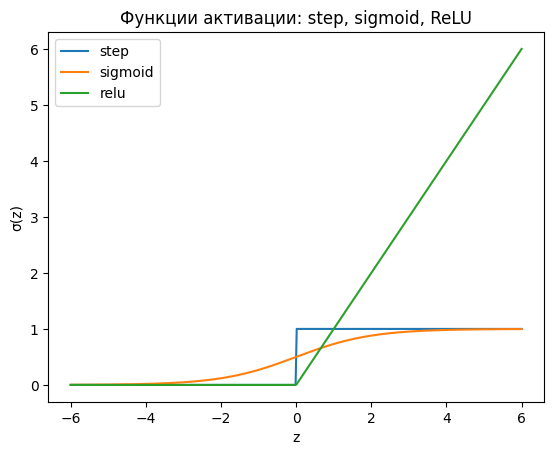

In [1]:
# Реализация простого искусственного нейрона с тремя популярными функциями активации
# быстрая демонстрация работы на игрушечных данных и визуализация кривых активации.
from __future__ import annotations
from dataclasses import dataclass
from typing import Callable, Literal
import numpy as np
import matplotlib.pyplot as plt


ActivationName = Literal["step", "sigmoid", "relu"]


def step(x: np.ndarray) -> np.ndarray:
    """Пороговая (ступенчатая) активация: 1 для x>=0, иначе 0."""
    return (x >= 0).astype(float)


def sigmoid(x: np.ndarray) -> np.ndarray:
    """Сигмоида: сглаженная нелинейность в интервале (0, 1)."""
    # Численно-устойчивая сигмоида
    out = np.empty_like(x, dtype=float)
    pos_mask = x >= 0
    neg_mask = ~pos_mask
    out[pos_mask] = 1 / (1 + np.exp(-x[pos_mask]))
    exp_x = np.exp(x[neg_mask])
    out[neg_mask] = exp_x / (1 + exp_x)
    return out


def relu(x: np.ndarray) -> np.ndarray:
    """ReLU: max(0, x)."""
    return np.maximum(0.0, x)


ACTIVATIONS: dict[ActivationName, Callable[[np.ndarray], np.ndarray]] = {
    "step": step,
    "sigmoid": sigmoid,
    "relu": relu,
}


@dataclass
class ArtificialNeuron:
    """
    Простой искусственный нейрон (однонейронная модель).

    Параметры
    ---------
    weights : np.ndarray
        Вектор весов формы (d,), где d — число признаков.
    bias : float
        Смещение (порог).
    activation : ActivationName
        Название функции активации: "step" | "sigmoid" | "relu".

    Методы
    ------
    forward(x):
        Возвращает выход y = sigma(w^T x + b) для батча объектов.
    """
    weights: np.ndarray
    bias: float = 0.0
    activation: ActivationName = "sigmoid"

    def __post_init__(self) -> None:
        if self.activation not in ACTIVATIONS:
            raise ValueError(f"Unknown activation '{self.activation}'.")
        self._act = ACTIVATIONS[self.activation]

    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Прямой проход.

        Параметры
        ---------
        x : np.ndarray
            Матрица входа формы (n, d), где n — число объектов.

        Возвращает
        ----------
        np.ndarray
            Вектор выхода формы (n,).
        """
        z = x @ self.weights + self.bias
        return self._act(z)


# --- Демонстрация для 2D-точек (x1, x2) и визуализация активаций по z
# Игрушечные данные:
X_demo = np.array([
    [0.0, 0.0],
    [1.0, 0.5],
    [-0.5, 1.0],
    [2.0, -1.0],
    [-1.5, -0.5],
], dtype=float)

w = np.array([0.8, -0.6])  # веса
b = 0.2                    # смещение

for name in ("step", "sigmoid", "relu"):
    neuron = ArtificialNeuron(weights=w, bias=b, activation=name)
    y = neuron.forward(X_demo)
    print(f"Activation={name:7s}  outputs={np.round(y, 4)}")

# Визуализация кривых активации как функции от z (один график на фигуру):
z_grid = np.linspace(-6, 6, 400)
plt.figure()
plt.plot(z_grid, step(z_grid), label="step")
plt.plot(z_grid, sigmoid(z_grid), label="sigmoid")
plt.plot(z_grid, relu(z_grid), label="relu")
plt.title("Функции активации: step, sigmoid, ReLU")
plt.xlabel("z")
plt.ylabel("σ(z)")
plt.legend()
plt.show()



# Перцептрон с учётом смещения (bias)

Точность на обучении: 1.000
Веса w: [0.143 0.107]  |  bias b: 0.000


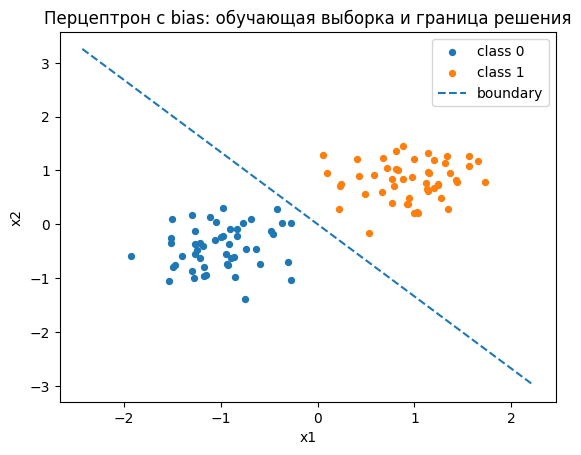

In [2]:
#Реализация обучаемого перцептрона с пороговой активацией и визуализацией разделяющей прямой.
from dataclasses import dataclass
from typing import Optional, Tuple


@dataclass
class Perceptron:
    """
    Классический перцептрон для линейно-разделимых данных.

    Параметры
    ---------
    lr : float
        Скорость обучения.
    n_epochs : int
        Число проходов по обучающему набору.
    shuffle : bool
        Перемешивать ли выборку на каждой эпохе.

    Атрибуты после обучения
    -----------------------
    w_ : np.ndarray
        Веса формы (d,).
    b_ : float
        Смещение (bias).
    """
    lr: float = 0.1
    n_epochs: int = 20
    shuffle: bool = True

    w_: Optional[np.ndarray] = None
    b_: float = 0.0

    def fit(self, X: np.ndarray, y: np.ndarray) -> "Perceptron":
        """
        Обучает перцептрон правилом обновления Розенблатта.

        Параметры
        ---------
        X : np.ndarray
            Матрица признаков формы (n, d).
        y : np.ndarray
            Целевые метки в {0, 1} формы (n,).

        Возвращает
        ----------
        self
        """
        n, d = X.shape
        rng = np.random.default_rng(42)
        self.w_ = np.zeros(d, dtype=float)
        self.b_ = 0.0

        # Переведём метки {0,1} в {-1, +1} для удобства правила обновления
        y_pm = np.where(y > 0, 1.0, -1.0)

        for epoch in range(self.n_epochs):
            idx = np.arange(n)
            if self.shuffle:
                rng.shuffle(idx)

            for i in idx:
                xi = X[i]
                yi = y_pm[i]
                z = xi @ self.w_ + self.b_
                y_hat = 1.0 if z >= 0 else -1.0
                if yi != y_hat:
                    # Обновление весов и смещения
                    self.w_ += self.lr * yi * xi
                    self.b_ += self.lr * yi
        return self

    def decision_function(self, X: np.ndarray) -> np.ndarray:
        """Возвращает z = w^T x + b для каждого объекта X."""
        assert self.w_ is not None
        return X @ self.w_ + self.b_

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Бинарные предсказания в {0,1}."""
        z = self.decision_function(X)
        return (z >= 0).astype(int)


# Синтетические линейно-разделимые данные в 2D
rng = np.random.default_rng(0)
n_per_class = 50
mean0 = np.array([-1.0, -0.5])
mean1 = np.array([1.0, 0.8])
X0 = rng.normal(mean0, 0.4, size=(n_per_class, 2))
X1 = rng.normal(mean1, 0.4, size=(n_per_class, 2))
X = np.vstack([X0, X1])
y = np.hstack([np.zeros(n_per_class, dtype=int), np.ones(n_per_class, dtype=int)])

# Обучение
clf = Perceptron(lr=0.1, n_epochs=30, shuffle=True).fit(X, y)
y_pred = clf.predict(X)
acc = (y_pred == y).mean()
print(f"Точность на обучении: {acc:.3f}")
print(f"Веса w: {np.round(clf.w_, 3)}  |  bias b: {clf.b_:.3f}")

# Визуализация точек и разделяющей прямой x2 = -(w1/w2)*x1 - b/w2
xx = np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 200)
w1, w2 = clf.w_
# Избежим деления на 0 при почти вертикальной границе:
if abs(w2) < 1e-8:
    # Рисуем вертикальную прямую x = -b/w1
    x_vert = -clf.b_ / w1
    plt.figure()
    plt.scatter(X0[:, 0], X0[:, 1], s=18, label="class 0")
    plt.scatter(X1[:, 0], X1[:, 1], s=18, label="class 1")
    plt.axvline(x_vert, linestyle="--", label="boundary")
    plt.title("Перцептрон с bias: обучающая выборка и граница решения")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.show()
else:
    yy = -(w1 / w2) * xx - (clf.b_ / w2)
    plt.figure()
    plt.scatter(X0[:, 0], X0[:, 1], s=18, label="class 0")
    plt.scatter(X1[:, 0], X1[:, 1], s=18, label="class 1")
    plt.plot(xx, yy, linestyle="--", label="boundary")
    plt.title("Перцептрон с bias: обучающая выборка и граница решения")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.show()


# SGD, Mini-batch, Momentum, RMSProp, Adam на логистической регрессии


# Стохастический градиентный спуск (SGD)

**Идея:** вместо вычисления точного градиента по всему датасету, мы используем приближение — градиент по одному или небольшому числу примеров (мини-батчу). Это делает шаг обучения значительно дешевле и позволяет быстрее обучать модели на больших данных.

---

## 1. Базовый градиентный спуск (full-batch)

Для параметров $ \theta \in \mathbb{R}^d $ и эмпирического риска

$$
\mathcal{L}(\theta) = \frac{1}{N}\sum_{i=1}^N \ell\big(f_\theta(x_i),\, y_i\big),
$$

шаг обновления имеет вид:

$$
\theta_{t+1} = \theta_t - \eta \,\nabla_\theta \mathcal{L}(\theta_t).
$$

Недостаток: каждый шаг требует прохода по всем $N$ объектам.

---

## 2. Стохастический градиентный спуск (по одному примеру)

$$
\theta_{t+1} = \theta_t - \eta \,\nabla_\theta \ell\big(f_{\theta_t}(x_{i_t}),\, y_{i_t}\big),
$$

где $i_t$ — случайный индекс.  
Градиент шумный, но шаг дешёвый → часто быстрее на больших данных.

---

## 3. Mini-batch SGD

Компромисс: используем мини-батч $B_t$ из $m$ объектов:

$$
g_t = \frac{1}{m}\sum_{i \in B_t} \nabla_\theta \ell\big(f_{\theta_t}(x_i),\, y_i\big), \qquad
\theta_{t+1} = \theta_t - \eta \, g_t.
$$

Плюсы: сглаживание шума и эффективная работа на GPU.

---

## 4. Улучшения SGD

### Momentum

$$
v_t = \mu v_{t-1} + \eta g_t, \qquad
\theta_{t+1} = \theta_t - v_t,
$$

где $ \mu \in [0,1) $ — коэффициент «инерции» (типично 0.9).

---

### RMSProp

$$
s_t = \rho s_{t-1} + (1 - \rho)\, g_t^2, \qquad
\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{s_t} + \varepsilon}\, g_t.
$$

---

### Adam (Momentum + RMSProp)

$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t, \quad
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2,
$$

с коррекцией смещения:

$$
\hat m_t = \frac{m_t}{1 - \beta_1^t}, \quad
\hat v_t = \frac{v_t}{1 - \beta_2^t}, \quad
\theta_{t+1} = \theta_t - \frac{\eta \, \hat m_t}{\sqrt{\hat v_t} + \varepsilon}.
$$

Типичные значения: $\beta_1=0.9$, $\beta_2=0.999$, $\varepsilon=10^{-8}$.

---

## 5. Практические советы

- **Перемешивание данных (shuffle)** перед каждой эпохой.  
- **Размер батча**: 16–256; меньший батч → больше шума, но лучше обобщение.  
- **Скорость обучения $\eta$** — ключевой гиперпараметр; часто используют **LR-scheduler**.  
- **Нормализация признаков**, BatchNorm стабилизируют обучение.  
- **Early stopping** и **градиент-клиппинг** (особенно в RNN).  


sgd        acc=0.977   final_loss=0.0712
momentum   acc=0.980   final_loss=0.0691
rmsprop    acc=0.977   final_loss=0.0690
adam       acc=0.980   final_loss=0.0794


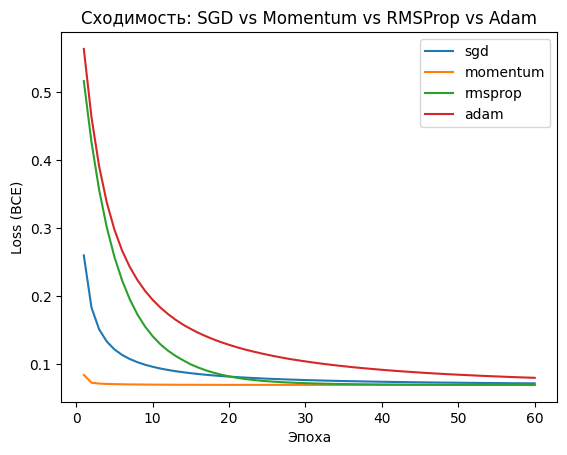

In [3]:
# SGD, Mini-batch, Momentum, RMSProp, Adam на логистической регрессии
# Демонстрация работы оптимизаторов на простой бинарной классификации.
# График: сходимость функции потерь для разных оптимизаторов.
from __future__ import annotations
from dataclasses import dataclass
from typing import Callable, Dict, Tuple, List
import numpy as np
import matplotlib.pyplot as plt


def make_toy_dataset(n: int = 400, seed: int = 0) -> Tuple[np.ndarray, np.ndarray]:
    """
    Генерирует линейно-разделимый датасет в 2D с шумом.
    Возвращает X формы (n, 2) и y в {0, 1} формы (n,).
    """
    rng = np.random.default_rng(seed)
    n2 = n // 2
    mean0, mean1 = np.array([-1.0, -0.3]), np.array([1.0, 0.8])
    X0 = rng.normal(mean0, 0.6, size=(n2, 2))
    X1 = rng.normal(mean1, 0.6, size=(n - n2, 2))
    X = np.vstack([X0, X1])
    y = np.hstack([np.zeros(n2, dtype=int), np.ones(n - n2, dtype=int)])
    # Перемешаем
    idx = rng.permutation(n)
    return X[idx], y[idx]


def sigmoid(z: np.ndarray) -> np.ndarray:
    """Численно-устойчивая сигмоида."""
    out = np.empty_like(z, dtype=float)
    pos = z >= 0
    neg = ~pos
    out[pos] = 1.0 / (1.0 + np.exp(-z[pos]))
    exp_z = np.exp(z[neg])
    out[neg] = exp_z / (1.0 + exp_z)
    return out


@dataclass
class LogisticModel:
    """
    Логистическая регрессия (без регуляризации) с ручными оптимизаторами.

    Параметры
    ---------
    d : int
        Число признаков.
    """
    d: int
    w: np.ndarray | None = None
    b: float = 0.0

    def __post_init__(self) -> None:
        if self.w is None:
            # Инициализация маленькими случайными значениями
            self.w = np.random.default_rng(42).normal(0, 0.01, size=(self.d,))

    def forward(self, X: np.ndarray) -> np.ndarray:
        """Линейная часть + сигмоида: p = P(y=1|x)."""
        z = X @ self.w + self.b
        return sigmoid(z)

    def loss_and_grad(self, X: np.ndarray, y: np.ndarray) -> Tuple[float, np.ndarray, float]:
        """
        Бинарная кросс-энтропия и её градиент по (w, b).
        Возвращает (loss, grad_w, grad_b).
        """
        p = self.forward(X)
        # Численно-устойчивая BCE
        eps = 1e-12
        loss = -np.mean(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps))
        # Градиенты
        diff = (p - y)  # формы (n,)
        grad_w = X.T @ diff / X.shape[0]
        grad_b = np.mean(diff)
        return loss, grad_w, grad_b

    def predict(self, X: np.ndarray) -> np.ndarray:
        return (self.forward(X) >= 0.5).astype(int)


def iterate_minibatches(X: np.ndarray, y: np.ndarray, batch_size: int, seed: int = 0):
    """Генератор мини-батчей с перемешиванием."""
    n = X.shape[0]
    rng = np.random.default_rng(seed)
    idx = rng.permutation(n)
    for start in range(0, n, batch_size):
        batch_idx = idx[start:start + batch_size]
        yield X[batch_idx], y[batch_idx]


def train_with_optimizer(
    X: np.ndarray,
    y: np.ndarray,
    optimizer: str = "sgd",
    lr: float = 0.1,
    batch_size: int = 32,
    epochs: int = 50,
    seed: int = 0,
) -> Tuple[LogisticModel, List[float]]:
    """
    Обучение логистической регрессии выбранным оптимизатором.

    Поддерживаемые оптимизаторы: "sgd", "momentum", "rmsprop", "adam".
    Возвращает обученную модель и список потерь по эпохам.
    """
    model = LogisticModel(d=X.shape[1])
    losses: List[float] = []

    # Состояния для оптимизаторов
    v_w = np.zeros_like(model.w)
    v_b = 0.0
    s_w = np.zeros_like(model.w)
    s_b = 0.0
    m_w = np.zeros_like(model.w)
    m_b = 0.0

    beta1, beta2 = 0.9, 0.999
    rho = 0.9
    eps = 1e-8

    t = 0  # счётчик шагов для Adam

    for epoch in range(epochs):
        # Эпоха: проход по мини-батчам
        for Xb, yb in iterate_minibatches(X, y, batch_size, seed + epoch):
            t += 1
            _, gw, gb = model.loss_and_grad(Xb, yb)

            if optimizer == "sgd":
                model.w -= lr * gw
                model.b -= lr * gb

            elif optimizer == "momentum":
                v_w = beta1 * v_w + lr * gw
                v_b = beta1 * v_b + lr * gb
                model.w -= v_w
                model.b -= v_b

            elif optimizer == "rmsprop":
                s_w = rho * s_w + (1 - rho) * (gw * gw)
                s_b = rho * s_b + (1 - rho) * (gb * gb)
                model.w -= lr * gw / (np.sqrt(s_w) + eps)
                model.b -= lr * gb / (np.sqrt(s_b) + eps)

            elif optimizer == "adam":
                m_w = beta1 * m_w + (1 - beta1) * gw
                m_b = beta1 * m_b + (1 - beta1) * gb
                s_w = beta2 * s_w + (1 - beta2) * (gw * gw)
                s_b = beta2 * s_b + (1 - beta2) * (gb * gb)
                # bias-correction
                m_w_hat = m_w / (1 - beta1**t)
                m_b_hat = m_b / (1 - beta1**t)
                s_w_hat = s_w / (1 - beta2**t)
                s_b_hat = s_b / (1 - beta2**t)
                model.w -= lr * m_w_hat / (np.sqrt(s_w_hat) + eps)
                model.b -= lr * m_b_hat / (np.sqrt(s_b_hat) + eps)

            else:
                raise ValueError(f"Unknown optimizer: {optimizer}")

        # Потеря по всей выборке в конце эпохи
        loss, _, _ = model.loss_and_grad(X, y)
        losses.append(loss)

    return model, losses


# --- Генерация данных и обучение разными оптимизаторами
X, y = make_toy_dataset(n=600, seed=1)

settings = {
    "sgd": dict(lr=0.2, batch_size=32, epochs=60),
    "momentum": dict(lr=0.15, batch_size=32, epochs=60),
    "rmsprop": dict(lr=0.01, batch_size=32, epochs=60),
    "adam": dict(lr=0.01, batch_size=32, epochs=60),
}

histories: Dict[str, List[float]] = {}
models: Dict[str, LogisticModel] = {}
for name, cfg in settings.items():
    model, losses = train_with_optimizer(X, y, optimizer=name, **cfg)
    histories[name] = losses
    models[name] = model

# --- Печать итоговой точности
for name, model in models.items():
    acc = (model.predict(X) == y).mean()
    print(f"{name:9s}  acc={acc:.3f}   final_loss={histories[name][-1]:.4f}")

# --- График: сходимость потерь по эпохам для всех оптимизаторов (одна фигура, без субплотов).
plt.figure()
for name, losses in histories.items():
    plt.plot(range(1, len(losses) + 1), losses, label=name)
plt.xlabel("Эпоха")
plt.ylabel("Loss (BCE)")
plt.title("Сходимость: SGD vs Momentum vs RMSProp vs Adam")
plt.legend()
plt.show()


# Важность функций активации и функций потерь

## Функции активации

Функция активации определяет, как выход нейрона зависит от взвешенной суммы входов:

$$
y = \sigma\!\left(\sum_{i=1}^n w_i x_i + b\right)
$$

Основные функции активации:

- **Ступенчатая (step)**:
  $$
  f(x) = \begin{cases}
  1, & x \geq 0 \\
  0, & x < 0
  \end{cases}
  $$

- **Сигмоида**:
  $$
  f(x) = \frac{1}{1 + e^{-x}}
  $$

- **ReLU (Rectified Linear Unit)**:
  $$
  f(x) = \max(0, x)
  $$

Функция активации делает модель *нелинейной* и позволяет нейросети приближать сложные зависимости.

---

## Функции потерь

Функция потерь измеряет, насколько предсказания модели отличаются от истинных значений.

- **Среднеквадратичная ошибка (MSE)** для регрессии:
  $$
  \text{MSE} = \frac{1}{N}\sum_{i=1}^N \big(\hat{y}_i - y_i\big)^2
  $$

- **Кросс-энтропия (Log Loss)** для классификации:
  $$
  \text{CE} = -\frac{1}{N}\sum_{i=1}^N \Big( y_i \log \hat{y}_i + (1-y_i)\log(1-\hat{y}_i) \Big)
  $$

---

👉 **Итог:**  
- Функция активации придаёт сети *нелинейность и выразительность*.  
- Функция потерь формулирует *цель обучения* и направляет оптимизацию.


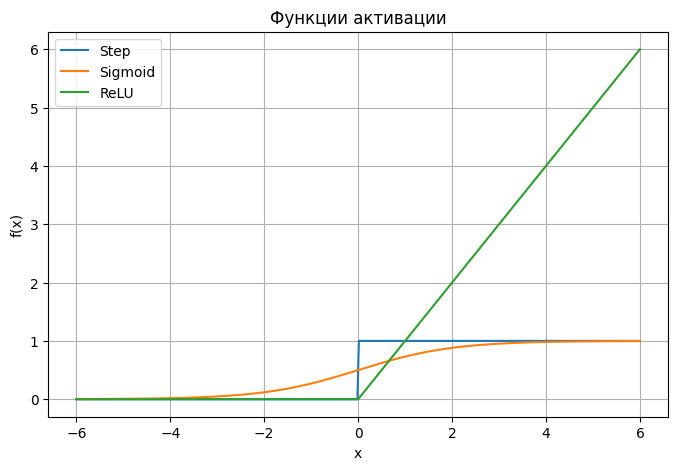

MSE  = 0.0620
CE   = 0.2603


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- Функции активации ---
def step(x): return (x >= 0).astype(float)
def sigmoid(x): return 1 / (1 + np.exp(-x))
def relu(x): return np.maximum(0, x)

x = np.linspace(-6, 6, 400)
plt.figure(figsize=(8, 5))
plt.plot(x, step(x), label="Step")
plt.plot(x, sigmoid(x), label="Sigmoid")
plt.plot(x, relu(x), label="ReLU")
plt.title("Функции активации")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.show()

# --- Функции потерь ---
# Истинные метки и предсказания
y_true = np.array([0, 1, 1, 0, 1])
y_pred = np.array([0.1, 0.9, 0.8, 0.4, 0.7])  # "вероятности"

# MSE
mse = np.mean((y_true - y_pred) ** 2)

# Cross-Entropy
eps = 1e-12
ce = -np.mean(y_true * np.log(y_pred + eps) + (1 - y_true) * np.log(1 - y_pred + eps))

print(f"MSE  = {mse:.4f}")
print(f"CE   = {ce:.4f}")


# Полносвязная нейронная сеть (MLP)

**Структура:**
- Входной слой: принимает исходные признаки $x_1, \dots, x_n$.
- Скрытые слои: линейное преобразование + нелинейная активация.
- Выходной слой: формирует предсказание (например, вероятность классов).

**Математическая модель одного слоя:**

$$
z_j = \sum_{i=1}^n w_{ij} x_i + b_j, \quad
a_j = f(z_j)
$$

где:
- $w_{ij}$ — веса,
- $b_j$ — смещение,
- $f$ — функция активации (например, ReLU или сигмоида).

**Общая запись для слоя:**

$$
\mathbf{a} = f(W \mathbf{x} + \mathbf{b})
$$

где $W$ — матрица весов, $\mathbf{b}$ — вектор смещений.


# Процесс обучения нейросети

## 1. Forward pass (прямое распространение)

Для сети с весами $W$ и активацией $f$:

$$
\hat{y} = f(Wx + b)
$$

Здесь $\hat{y}$ — предсказание сети.

---

## 2. Вычисление функции потерь

Например, для бинарной классификации используем кросс-энтропию:

$$
L = - \frac{1}{N} \sum_{i=1}^N \Big[ y_i \log \hat{y}_i + (1-y_i)\log(1-\hat{y}_i) \Big]
$$

---

## 3. Backward pass (обратное распространение)

Мы хотим обновить веса, используя градиент ошибки.

- Для одного веса $w_j$:

$$
\frac{\partial L}{\partial w_j} = \frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial z} \cdot \frac{\partial z}{\partial w_j}
$$

где $z = Wx + b$.

---

## 4. Обновление весов (градиентный спуск)

$$
w_j \leftarrow w_j - \eta \, \frac{\partial L}{\partial w_j}, \quad
b \leftarrow b - \eta \, \frac{\partial L}{\partial b}
$$

где $\eta$ — скорость обучения (learning rate).


In [5]:
import numpy as np

# --- Датасет: логическая операция AND
X = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([0,0,0,1])

# --- Инициализация весов и смещения
rng = np.random.default_rng(42)
w = rng.normal(0, 0.1, size=2)
b = 0.0

# --- Гиперпараметры
lr = 0.8
epochs = 100

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss(y_true, y_pred):
    eps = 1e-12
    return -np.mean(y_true*np.log(y_pred+eps) + (1-y_true)*np.log(1-y_pred+eps))

# --- Обучение
for epoch in range(epochs):
    # forward
    z = X @ w + b
    y_pred = sigmoid(z)

    # loss
    L = loss(y, y_pred)

    # backward
    grad_z = y_pred - y
    grad_w = X.T @ grad_z / len(y)
    grad_b = np.mean(grad_z)

    # обновление весов
    w -= lr * grad_w
    b -= lr * grad_b

    if epoch % 25 == 0:
        print(f"Epoch {epoch:2d}, Loss={L:.4f}")

# --- Проверка
print("Предсказания после обучения:", (sigmoid(X @ w + b) >= 0.5).astype(int))


Epoch  0, Loss=0.6937
Epoch 25, Loss=0.3634
Epoch 50, Loss=0.2592
Epoch 75, Loss=0.2036
Предсказания после обучения: [0 0 0 1]


## A: Невозможность сойтись на XOR одной линейной моделью (логистическая регрессия)

In [6]:
# Cell A: Невозможность сойтись на XOR одной линейной моделью (логистическая регрессия)
import numpy as np

# Датасет XOR
X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
y = np.array([0,1,1,0], dtype=float)

# Инициализация параметров логистической регрессии
rng = np.random.default_rng(0)
w = rng.normal(0, 0.1, size=2)
b = 0.0

def sigmoid(z):
    out = np.empty_like(z, dtype=float)
    pos = z >= 0
    neg = ~pos
    out[pos] = 1.0 / (1.0 + np.exp(-z[pos]))
    ez = np.exp(z[neg])
    out[neg] = ez / (1.0 + ez)
    return out

def bce(y_true, y_pred, eps=1e-12):
    return -np.mean(y_true*np.log(y_pred+eps) + (1-y_true)*np.log(1-y_pred+eps))

# Обучение (градиентный спуск по всему батчу)
lr = 0.5
epochs = 5000
loss_hist = []
for epoch in range(epochs):
    z = X @ w + b
    p = sigmoid(z)
    # Градиенты BCE по w, b
    diff = (p - y)                   # dL/dz
    gw = X.T @ diff / len(y)
    gb = np.mean(diff)
    # Шаг
    w -= lr * gw
    b -= lr * gb
    if epoch % 250 == 0:
        loss_hist.append(bce(y, p))

final_loss = bce(y, sigmoid(X @ w + b))
pred = (sigmoid(X @ w + b) >= 0.5).astype(int)

print("Логистическая регрессия на XOR (1 слой):")
print(f"  Финальный loss: {final_loss:.4f}")
print(f"  Предсказания:   {pred.tolist()} (истина: {[int(v) for v in y]})")
print("  Примечание: задача XOR не линейно-разделима → линейная модель не достигает идеальной точности.")


Логистическая регрессия на XOR (1 слой):
  Финальный loss: 0.6931
  Предсказания:   [1, 1, 1, 1] (истина: [0, 1, 1, 0])
  Примечание: задача XOR не линейно-разделима → линейная модель не достигает идеальной точности.


## B: Сходимость на XOR с одним скрытым слоем (MLP, numpy, tanh + sigmoid)

In [7]:
# Retry Cell B with safer hyperparams (lr=0.5, longer epochs, smaller init)
import numpy as np

X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
y = np.array([0,1,1,0], dtype=float).reshape(-1,1)

rng = np.random.default_rng(3)

H = 3
W1 = rng.normal(0, 0.3, size=(2, H))
b1 = np.zeros((1, H))
W2 = rng.normal(0, 0.3, size=(H, 1))
b2 = np.zeros((1, 1))

def tanh(x): return np.tanh(x)
def dtanh(x): return 1 - np.tanh(x)**2
def sigmoid(z):
    out = np.empty_like(z, dtype=float)
    pos = z >= 0
    neg = ~pos
    out[pos] = 1.0 / (1.0 + np.exp(-z[pos]))
    ez = np.exp(z[neg])
    out[neg] = ez / (1.0 + ez)
    return out
def bce(y_true, y_pred, eps=1e-12):
    return -np.mean(y_true*np.log(y_pred+eps) + (1-y_true)*np.log(1-y_pred+eps))

lr = 0.5
epochs = 20000

for epoch in range(epochs):
    z1 = X @ W1 + b1
    a1 = tanh(z1)
    z2 = a1 @ W2 + b2
    p  = sigmoid(z2)

    dz2 = (p - y)
    dW2 = a1.T @ dz2 / len(X)
    db2 = np.mean(dz2, axis=0, keepdims=True)

    da1 = dz2 @ W2.T
    dz1 = da1 * dtanh(z1)
    dW1 = X.T @ dz1 / len(X)
    db1 = np.mean(dz1, axis=0, keepdims=True)

    W2 -= lr * dW2
    b2 -= lr * db2
    W1 -= lr * dW1
    b1 -= lr * db1

z1 = X @ W1 + b1
a1 = tanh(z1)
z2 = a1 @ W2 + b2
p  = sigmoid(z2)
pred = (p >= 0.5).astype(int).flatten().tolist()

print("MLP (1 скрытый слой) на XOR (стабильная сходимость):")
print(f"  Предсказания: {pred} (истина: {[int(v) for v in y.flatten()]} )")
print(f"  Вероятности:  {[round(float(v), 4) for v in p.flatten()]}")
print(f"  Loss:         {bce(y, p):.6f}")


MLP (1 скрытый слой) на XOR (стабильная сходимость):
  Предсказания: [0, 1, 1, 0] (истина: [0, 1, 1, 0] )
  Вероятности:  [0.0, 0.9997, 0.9997, 0.0004]
  Loss:         0.000251


# Markdown cell: Введение в операции свёртки (формулы) и базовый блок CNN

![](https://miro.medium.com/v2/resize:fit:2000/format:webp/0*zn7lzvIUv1j825uY.png)

# Введение в операции свёртки и базовый блок CNN

![](https://miro.medium.com/v2/resize:fit:2000/format:webp/0*SWdZjUqusuWLu9cg.png)

## Свёртка (convolution)
Пусть у нас есть входная карта признаков \(X \in \mathbb{R}^{H\times W}\) и ядро свёртки \(K \in \mathbb{R}^{k\times k}\).
Тогда выход \(Y \in \mathbb{R}^{H'\times W'}\) при шаге \(s\) и дополнении нулями (padding) \(p\) вычисляется как:

- Пространственные размеры выхода:
$$
H'=\left\lfloor \frac{H+2p-k}{s} \right\rfloor + 1,\quad
W'=\left\lfloor \frac{W+2p-k}{s} \right\rfloor + 1.
$$

- Элемент выхода (для одной карты признаков и одного ядра):
$$
Y[i,j] \;=\; \sum_{u=0}^{k-1}\sum_{v=0}^{k-1} K[u,v] \;\cdot\; \tilde{X}[\,i\cdot s + u,\; j\cdot s + v\,],
$$
где \(\tilde{X}\) — вход \(X\), дополненный нулями по краям на \(p\) пикселей.

Если вход многоканальный \(X \in \mathbb{R}^{H\times W \times C}\), а фильтр имеет каналы \(K \in \mathbb{R}^{k\times k \times C}\), то свёртка суммируется по каналам:
$$
Y[i,j] \;=\; \sum_{c=1}^{C}\sum_{u=0}^{k-1}\sum_{v=0}^{k-1} K[u,v,c]\;\cdot\; \tilde{X}[\,i\cdot s + u,\; j\cdot s + v,\; c\,].
$$

## Нелинейность (ReLU)
После свёртки применяется нелинейность, чаще всего ReLU:
$$
\mathrm{ReLU}(z) \;=\; \max(0, z).
$$

## Max-pooling
Max-pooling с окном \(p_h \times p_w\) и шагом \((s_h, s_w)\) берёт максимум в каждом окне:
$$
P[i,j] \;=\; \max_{\;0\le u < p_h,\;0\le v < p_w}\; Z[\,i\cdot s_h + u,\; j\cdot s_w + v\,].
$$

Итоговый **блок CNN**:
1) `Conv2D(k×k, stride, padding)` → 2) `ReLU` → 3) `MaxPooling`.

![](https://miro.medium.com/v2/resize:fit:2000/format:webp/0*QzavkkvniI3dGRo3.png)

Ниже — минимальный пример на `numpy` для одной карты признаков (grayscale), ядра \(3\times3\), `ReLU` и `max-pooling` \(2\times2\) со сдвигом 2.


Shapes:
 img      : (10, 10)
 conv_out : (10, 10)
 relu_out : (10, 10)
 pool_out : (5, 5)


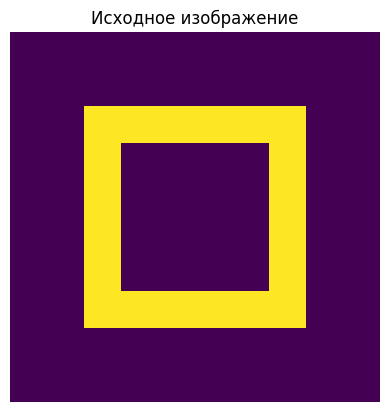

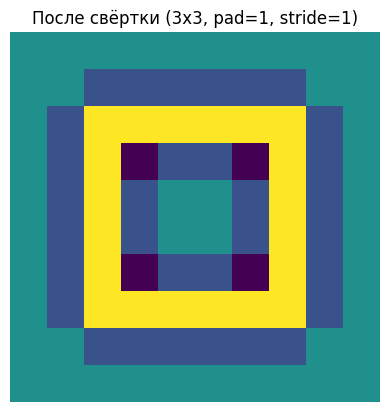

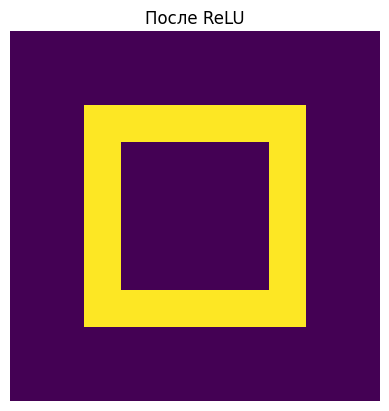

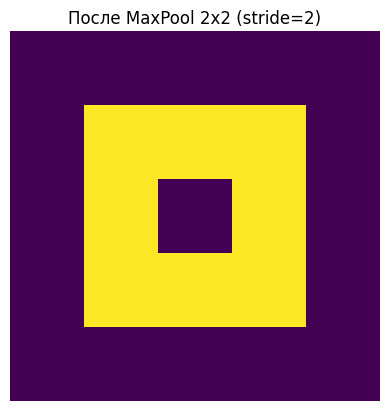

In [8]:
# Code cell: минимальный пример Conv2D(3x3) + ReLU + MaxPool(2x2) на numpy
import numpy as np
import matplotlib.pyplot as plt

def pad2d(x: np.ndarray, pad: int) -> np.ndarray:
    if pad <= 0:
        return x
    H, W = x.shape
    out = np.zeros((H + 2*pad, W + 2*pad), dtype=float)
    out[pad:pad+H, pad:pad+W] = x
    return out

def conv2d_single(x: np.ndarray, k: np.ndarray, stride: int = 1, pad: int = 0) -> np.ndarray:
    """
    x: (H, W) — вход (grayscale)
    k: (k, k) — ядро свёртки
    Возвращает Y: (H_out, W_out)
    """
    x_pad = pad2d(x, pad)
    H, W = x_pad.shape
    kh, kw = k.shape
    H_out = (H - kh) // stride + 1
    W_out = (W - kw) // stride + 1
    y = np.zeros((H_out, W_out), dtype=float)
    for i in range(H_out):
        for j in range(W_out):
            region = x_pad[i*stride:i*stride+kh, j*stride:j*stride+kw]
            y[i, j] = np.sum(region * k)
    return y

def relu(x: np.ndarray) -> np.ndarray:
    return np.maximum(0.0, x)

def maxpool2d(x: np.ndarray, pool: int = 2, stride: int = 2) -> np.ndarray:
    H, W = x.shape
    H_out = (H - pool) // stride + 1
    W_out = (W - pool) // stride + 1
    y = np.zeros((H_out, W_out), dtype=float)
    for i in range(H_out):
        for j in range(W_out):
            region = x[i*stride:i*stride+pool, j*stride:j*stride+pool]
            y[i, j] = np.max(region)
    return y

# 1) Игрушечное изображение: квадрат с яркой рамкой
img = np.zeros((10, 10), dtype=float)
img[2:8, 2] = 1.0
img[2:8, 7] = 1.0
img[2, 2:8] = 1.0
img[7, 2:8] = 1.0

# 2) Ядро 3x3 (детектор горизонтальных + вертикальных граней — простое Laplacian-подобное)
kernel = np.array([[0, -1, 0],
                   [-1, 4, -1],
                   [0, -1, 0]], dtype=float)

# Свёртка (padding=1, stride=1) — чтобы сохранить размерность
conv_out = conv2d_single(img, kernel, stride=1, pad=1)
relu_out = relu(conv_out)
pool_out = maxpool2d(relu_out, pool=2, stride=2)

print("Shapes:")
print(" img      :", img.shape)
print(" conv_out :", conv_out.shape)
print(" relu_out :", relu_out.shape)
print(" pool_out :", pool_out.shape)

# Визуализация (каждый результат на отдельной фигуре, как и положено по правилам)
plt.figure()
plt.title("Исходное изображение")
plt.imshow(img)
plt.axis("off")
plt.show()

plt.figure()
plt.title("После свёртки (3x3, pad=1, stride=1)")
plt.imshow(conv_out)
plt.axis("off")
plt.show()

plt.figure()
plt.title("После ReLU")
plt.imshow(relu_out)
plt.axis("off")
plt.show()

plt.figure()
plt.title("После MaxPool 2x2 (stride=2)")
plt.imshow(pool_out)
plt.axis("off")
plt.show()


# Inception_v3

*Author: Pytorch Team*

**Also called GoogleNetv3, a famous ConvNet trained on ImageNet from 2015**

<img src="https://pytorch.org/assets/images/inception_v3.png" alt="alt" width="50%"/>

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.eval()

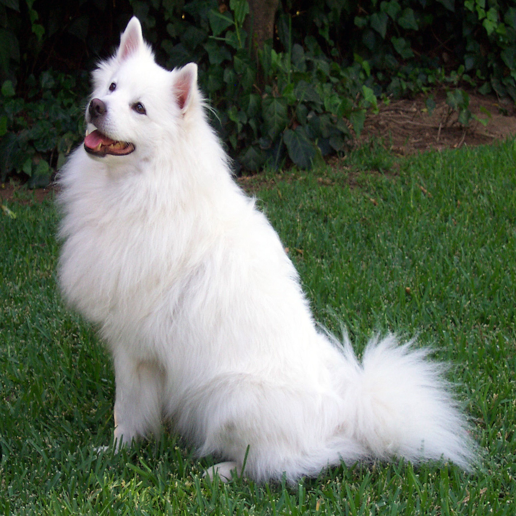

In [ ]:
# Download an example image from the pytorch website
import urllib
from PIL import Image
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

Image.open(filename).resize((516, 516), Image.Resampling.BICUBIC)

In [ ]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
  output = model(input_batch)
# Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

tensor([ 1.5696e-01,  1.1051e-01, -4.4363e-01, -6.1477e-02, -2.0093e-01,
         1.6820e-01,  5.8117e-01,  6.0333e-02, -7.7652e-02, -1.1192e+00,
        -2.1800e-01, -5.2624e-01, -1.1816e-01,  6.6276e-02,  8.4988e-01,
        -5.3259e-02, -4.7113e-01, -2.6000e-03,  2.7504e-01,  1.7060e-01,
         4.4231e-01, -3.8615e-01,  1.3482e-01, -5.2202e-01, -3.3664e-04,
        -2.3492e-01, -2.3264e-01, -7.1882e-03,  1.6899e-02, -1.2724e-01,
         2.0508e-01, -6.9889e-03,  1.3074e+00, -2.3181e-01,  9.8966e-01,
        -7.7782e-01,  4.8900e-01, -4.2244e-01, -2.6523e-01, -1.5005e-01,
         3.5147e-01, -1.7462e-01,  1.0251e-01,  4.2223e-01, -1.4342e-01,
         1.3578e-02, -4.6477e-01,  3.5966e-01,  1.5194e-01,  2.0217e-01,
        -1.3763e-01,  1.4986e-01,  2.8415e-01, -3.7086e-01,  9.7688e-01,
         7.9543e-01, -7.4032e-01, -7.8853e-02, -9.6365e-02,  1.2193e-01,
        -1.2712e-01,  3.6825e-01, -4.5355e-01, -7.4801e-01, -7.9356e-02,
         2.1688e-01,  2.7018e-01,  1.0089e+00,  4.0

In [ ]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2025-09-28 19:06:06--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2025-09-28 19:06:06 (43.5 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [ ]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

Samoyed 0.8238474130630493
Arctic fox 0.0141915800049901
white wolf 0.01230352371931076
Pomeranian 0.007874660193920135
keeshond 0.006387806963175535


## torchinfo

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

summary(model=model)

Layer (type:depth-idx)                   Param #
Inception3                               --
├─BasicConv2d: 1-1                       --
│    └─Conv2d: 2-1                       864
│    └─BatchNorm2d: 2-2                  64
├─BasicConv2d: 1-2                       --
│    └─Conv2d: 2-3                       9,216
│    └─BatchNorm2d: 2-4                  64
├─BasicConv2d: 1-3                       --
│    └─Conv2d: 2-5                       18,432
│    └─BatchNorm2d: 2-6                  128
├─MaxPool2d: 1-4                         --
├─BasicConv2d: 1-5                       --
│    └─Conv2d: 2-7                       5,120
│    └─BatchNorm2d: 2-8                  160
├─BasicConv2d: 1-6                       --
│    └─Conv2d: 2-9                       138,240
│    └─BatchNorm2d: 2-10                 384
├─MaxPool2d: 1-7                         --
├─InceptionA: 1-8                        --
│    └─BasicConv2d: 2-11                 --
│    │    └─Conv2d: 3-1                  12,288
│   

## torchview

In [ ]:
!pip install torchview graphviz
# + graphviz как выше (apt/installer)


In [ ]:
import torch
from torchview import draw_graph

device = torch.device("cpu")
#model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True).to(device).eval()

graph = draw_graph(
    model,
    input_size=(1, 3, 299, 299),  # NCHW
    device=device,
    expand_nested=True,           # развернуть вложенные модули
    save_graph=True,
    filename="inception_v3_torchview",
    graph_dir=".",                # куда сохранить
    # graph_format="png",           # png/pdf/svg # Removed
)
print("Saved: inception_v3_torchview.png")


Saved: inception_v3_torchview.png


In [ ]:
Image.open("/content/inception_v3_torchview.png")

Output hidden; open in https://colab.research.google.com to view.

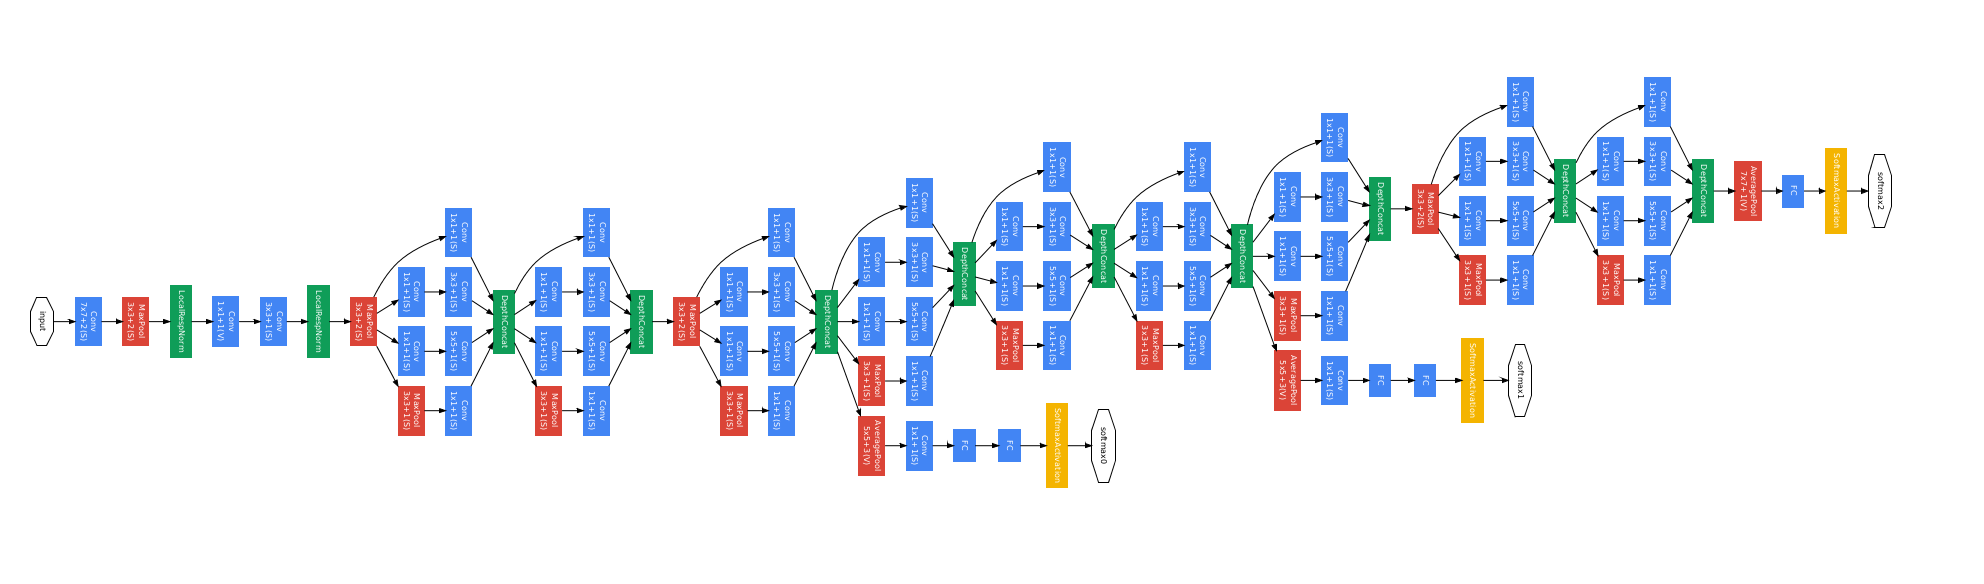

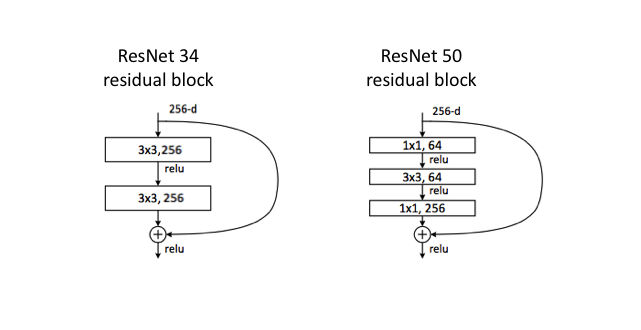